<div align="center"><h3>HW3</h3></div>
<div align="center"><h5>Mohammadreza Ghofrani, 400131076</h5></div>

In [1]:
import os
# To disable gpu warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances

Loading Datasets

In [3]:
X_train = pd.read_csv('data/train/X_train.txt', delim_whitespace=True, header=None).to_numpy()
y_train = np.squeeze(pd.read_csv('data/train/y_train.txt', delim_whitespace=True, header=None).to_numpy() - 1)
X_test = pd.read_csv('data/test/X_test.txt', delim_whitespace=True, header=None).to_numpy()
y_test = np.squeeze(pd.read_csv('data/test/y_test.txt', delim_whitespace=True, header=None).to_numpy() - 1)

Constants used in this notebook

In [4]:
NUM_OF_ACTIVITY = len(np.unique(y_train))
NUM_OF_FEATURES = X_train.shape[1]

Based on the problem specification we should split dataset into train, test and validation with 
ratio 7, 1, 2. Author of this dataset, already provided 70% of data as train and 30% as test. We 
preserve the train dataset, but we use 0.7 percent of test dataset as validation and the rest as
test.

In [5]:
X_val = X_test[:int(0.7*len(X_test))]
y_val = y_test[:int(0.7*len(y_test))]
X_test = X_test[int(0.7*len(X_test)):]
y_test = y_test[int(0.7*len(y_test)):]

Encoding output as one-hot encoding

In [6]:
y_train_onehot = np.squeeze(tf.one_hot(y_train, NUM_OF_ACTIVITY).numpy())
y_val_onehot = np.squeeze(tf.one_hot(y_val, NUM_OF_ACTIVITY).numpy())
y_test_onehot = np.squeeze(tf.one_hot(y_test, NUM_OF_ACTIVITY).numpy())

## Multilayer Perceptron

In [8]:
tf.keras.backend.clear_session()
mlp = tf.keras.Sequential([
    tf.keras.layers.Dense(NUM_OF_FEATURES, activation='relu'),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(NUM_OF_ACTIVITY, activation='softmax'),
])

mlp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

mlp.fit(X_train, y_train_onehot, validation_data=(X_val, y_val_onehot), epochs=30, batch_size=512)

Epoch 1/30
15/15 [==============================] - 1s 67ms/step - loss: 0.8518 - accuracy: 0.7089 - val_loss: 0.3878 - val_accuracy: 0.8264
Epoch 2/30
15/15 [==============================] - 1s 60ms/step - loss: 0.2851 - accuracy: 0.8785 - val_loss: 0.2658 - val_accuracy: 0.8812
Epoch 3/30
15/15 [==============================] - 1s 60ms/step - loss: 0.1776 - accuracy: 0.9246 - val_loss: 0.2319 - val_accuracy: 0.8952
Epoch 4/30
15/15 [==============================] - 1s 60ms/step - loss: 0.1582 - accuracy: 0.9316 - val_loss: 0.1803 - val_accuracy: 0.9277
Epoch 5/30
15/15 [==============================] - 1s 60ms/step - loss: 0.1270 - accuracy: 0.9483 - val_loss: 0.1700 - val_accuracy: 0.9219
Epoch 6/30
15/15 [==============================] - 1s 60ms/step - loss: 0.0961 - accuracy: 0.9604 - val_loss: 0.1557 - val_accuracy: 0.9306
Epoch 7/30
15/15 [==============================] - 1s 61ms/step - loss: 0.0721 - accuracy: 0.9727 - val_loss: 0.1552 - val_accuracy: 0.9345
Epoch 8/30
15

In [9]:
mlp.evaluate(X_test, y_test_onehot)

28/28 [==============================] - 0s 3ms/step - loss: 0.1077 - accuracy: 0.9695


[0.10767461359500885, 0.9694915413856506]

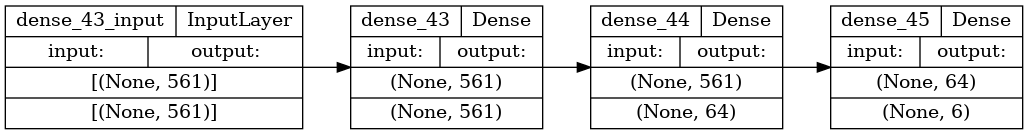

In [26]:
tf.keras.utils.plot_model(mlp, show_shapes=True, rankdir="LR")

# Self Organizing Map

In [10]:
class SOM:
    def __init__(self, map_size, alpha, lr, R, T, path):
        """
        map_size: [map_w, map_h, feature]
        """
        self.T = T
        self.alpha = alpha
        self.map = np.random.rand(map_size[0], map_size[1], map_size[2])
        self.total_number_of_nn = map_size[0] * map_size[1]
        self.lr0 = lr
        self.lr = self.lr0
        self.R = R
        self.path = path
        assert(self.lr >= self.T * self.alpha)
        with open(os.path.join(self.path, 'log.txt'), 'w') as f:
            f.write('T={}, alpha={}, lr={}, R={}, map_size={}'.format(T, alpha, lr, R, map_size))

    def train(self, X, y):
        self.initialize_weights(X)
        dead_nn_stat = list()
        mean_dist_stat = list()
        Js = list()
        self.draw_clustering_and_umatrix(X, y)
        for t in tqdm(range(self.T)):
            epoch_winner_nn = set()
            epoch_sum_dist = 0
            prev_map = self.map.copy()
            shuffle_ind = np.random.randint(low=0, high=len(X), size=len(X))
            for i in range(len(X)):
                x = X[shuffle_ind[i],:]

                winner, d = self.find_winner(x)
                ns = self.get_ns(winner)
                epoch_winner_nn.add(winner)

                self.update_weights(x, ns)
                epoch_sum_dist += d

            self.lr = self.lr0 - self.alpha * t

            dead_nn_stat.append(self.total_number_of_nn - len(epoch_winner_nn))
            mean_dist_stat.append(epoch_sum_dist/len(X))
            Js.append(np.linalg.norm(self.map - prev_map))
        self.draw_clustering_and_umatrix(X, y)
        self.draw_dead_nn_diagram(dead_nn_stat)
        self.draw_mean_stat_diagram(mean_dist_stat)
        self.draw_Js_digram(Js)

    def initialize_weights(self, X):
        for i in range(len(self.map)):
            for j in range(len(self.map[i])):
                rand_ind = np.random.randint(low=0, high=len(X))
                self.map[i,j] = X[rand_ind]

    def draw_clustering_and_umatrix(self, X, y):
        num_of_activity = len(np.unique(y))
        scores_argmax = np.zeros(shape=(self.map.shape[0], self.map.shape[1], 3))
        scores_cmb = np.zeros(shape=(self.map.shape[0], self.map.shape[1], 3))
        score_cnt = np.zeros(shape=(self.map.shape[0], self.map.shape[1]))
        member_cnt = np.zeros(shape=(self.map.shape[0], self.map.shape[1], num_of_activity))
        colors = [
            np.array([1,0,0]),
            np.array([0,1,0]),
            np.array([0,0,1]),
            np.array([1,1,0]),
            np.array([0,1,1]),
            np.array([1,0,1])
        ]

        a = 0
        for i in range(len(X)):
            x = X[i,:]
            y_ = y[i]
            winner, _ = self.find_winner(x)
            scores_cmb[winner] += colors[y_]
            score_cnt[winner] += 1
            member_cnt[winner][y_] += 1
            a += 1

        for i in range(len(member_cnt)):
            for j in range(len(member_cnt[i])):
                if any(member_cnt[i,j]):
                    scores_cmb[i,j] /= (np.sum(member_cnt[i,j]) + 1)
                    scores_argmax[i,j] = colors[np.argmax(member_cnt[i,j])]

        fig, (ax1, ax2) = plt.subplots(1,2)
        ax1.imshow(scores_cmb)
        ax2.imshow(scores_argmax)
        fig.suptitle('Clusters Visualization')
        ax1.set_title('Combining members colors')
        ax2.set_title('Argmax member colors')
        ax1.tick_params(axis='both', which='both', labelbottom=False, labelleft=False,
                        bottom=False, left=False)
        ax2.tick_params(axis='both', which='both', labelbottom=False, labelleft=False,
                        bottom=False, left=False)
        plt.savefig(os.path.join(self.path, 'cluster.png'))
        plt.show()
        plt.imshow(score_cnt, cmap='Reds')
        plt.savefig(os.path.join(self.path, 'umatrix.png'))
        plt.show()

    def draw_dead_nn_diagram(self, dead_nn_stat):
        epoch = list(range(self.T))
        plt.plot(epoch, dead_nn_stat)
        plt.title('Dead Neurons per Epoch')
        plt.xlabel('epoch')
        plt.ylabel('Frequency')
        plt.savefig(os.path.join(self.path, 'dead.png'))
        plt.show()

    def draw_Js_digram(self, Js):
        epoch = list(range(self.T))
        plt.plot(epoch, Js)
        plt.title('Weight Changes per Epoch')
        plt.xlabel('epoch')
        plt.ylabel('Frequency')
        plt.savefig(os.path.join(self.path, 'weight_change.png'))
        plt.show()

    def draw_mean_stat_diagram(self, mean_dist_stat):
        epoch = list(range(self.T))
        plt.plot(epoch, mean_dist_stat)
        plt.title('Winner Neuron Mean Distance per Epoch')
        plt.xlabel('epoch')
        plt.ylabel('Distance')
        plt.savefig(os.path.join(self.path, 'winner_distance.png'))
        plt.show()

    def find_winner(self, x):
        map_ = self.map.reshape((self.map.shape[0] * self.map.shape[1], self.map.shape[2]))
        distances_from_x_to_out_nodes = euclidean_distances(map_, [x])
        winner_node = np.argmin(distances_from_x_to_out_nodes)
        winner_node_ = np.unravel_index(winner_node, (self.map.shape[0],self.map.shape[1]))
        winner_node_distance = distances_from_x_to_out_nodes[winner_node]
        return winner_node_, winner_node_distance

    def get_ns(self, winner):
        ns = np.zeros(shape=(self.map.shape[0], self.map.shape[1]))
        iw, jw = winner[0], winner[1]
        R = int(self.R)
        for ri in range(-R, R+1):
            for rj in range(-R, R+1):
                if (0 <= iw + ri < self.map.shape[0]) and (0 <= jw + rj < self.map.shape[1]):
                    d = np.sqrt(ri**2 + rj**2)
                    ns[iw+ri, jw+rj] = 0 if d > R else 1/(d+1)
        return ns

    def update_weights(self, x, ns):
        X = np.tile(x, (self.map.shape[0], self.map.shape[1], 1))
        NS = np.tile(ns.T, (self.map.shape[2], 1,1)).T
        self.map += self.lr * np.multiply((X - self.map), NS)

    def reduce_dimension_using_index(self, X):
        new_X = np.zeros((X.shape[0], 2))
        for i, x in enumerate(X):
            winner, _ = self.find_winner(x)
            new_X[i] = np.array(winner)
        return new_X

    def reduce_dimension_using_distance(self, X):
        new_X = np.zeros((X.shape[0], self.map.shape[0] * self.map.shape[1]))
        map_ = self.map.copy().reshape(self.map.shape[0] * self.map.shape[1], self.map.shape[2])
        for i, x in enumerate(X):
            new_X[i] = euclidean_distances(np.array([x]), map_)
        return new_X

    def reduce_dimension(self, X, using_index=False):
        if using_index:
            return self.reduce_dimension_using_index(X)
        else:
            return self.reduce_dimension_using_distance(X)

In [11]:
run = 19
os.makedirs(f'images/q5/r{run}/', exist_ok=True)
som = SOM((13, 13, 561), R=5, lr=0.1, T=20, alpha=0.005, path=f'images/q5/r{run}/')
som.train(X_train, y_train)

KeyboardInterrupt: 

# Question 6

Extracting features using 13 by 13 SOM map

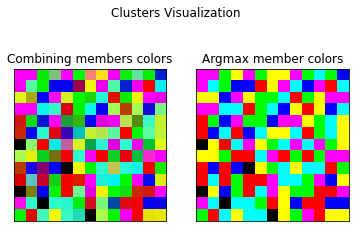

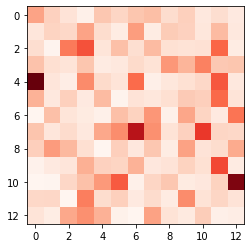

100%|██████████| 20/20 [04:43<00:00, 14.15s/it]


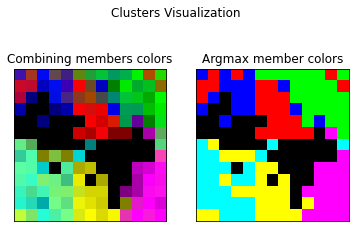

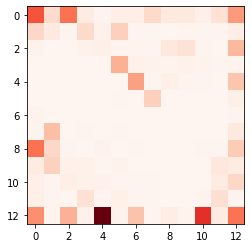

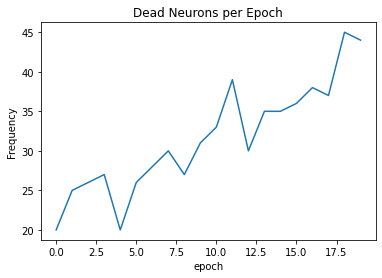

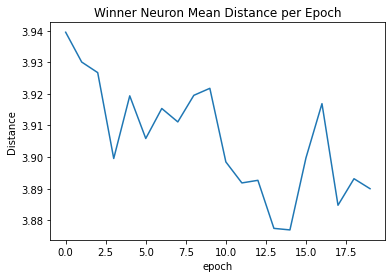

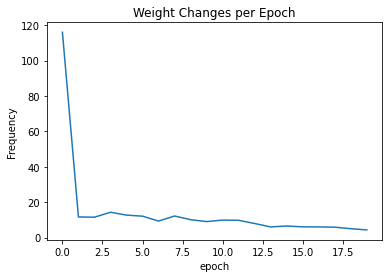

In [12]:
som13by13 = SOM((13, 13, 561), R=7, lr=0.1, T=20, alpha=0.005, path=f'/tmp/')
som13by13.train(X_train, y_train)

In [13]:
X_train_13by13_distance_based = som13by13.reduce_dimension(X_train)
X_val_13by13_distance_based = som13by13.reduce_dimension(X_val)
X_test_13by13_distance_based = som13by13.reduce_dimension(X_test)

In [17]:
mlp = tf.keras.Sequential([
    tf.keras.layers.Dense(NUM_OF_FEATURES, activation='relu'),
    tf.keras.layers.Dense(8192, activation='relu'),
    tf.keras.layers.Dense(NUM_OF_ACTIVITY, activation='softmax'),
])

mlp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

mlp.fit(X_train_13by13_distance_based, y_train_onehot, validation_data=(X_val_13by13_distance_based, y_val_onehot), epochs=30, batch_size=1024)

Epoch 1/30
8/8 [==============================] - 0s 32ms/step - loss: 1.9654 - accuracy: 0.3871 - val_loss: 1.0829 - val_accuracy: 0.4292
Epoch 2/30
8/8 [==============================] - 0s 20ms/step - loss: 0.9713 - accuracy: 0.5135 - val_loss: 0.8113 - val_accuracy: 0.6508
Epoch 3/30
8/8 [==============================] - 0s 21ms/step - loss: 0.8140 - accuracy: 0.6106 - val_loss: 0.7393 - val_accuracy: 0.6828
Epoch 4/30
8/8 [==============================] - 0s 20ms/step - loss: 0.7248 - accuracy: 0.6737 - val_loss: 0.7453 - val_accuracy: 0.6993
Epoch 5/30
8/8 [==============================] - 0s 19ms/step - loss: 0.6934 - accuracy: 0.6844 - val_loss: 0.6791 - val_accuracy: 0.6954
Epoch 6/30
8/8 [==============================] - 0s 19ms/step - loss: 0.6606 - accuracy: 0.7055 - val_loss: 0.6437 - val_accuracy: 0.7730
Epoch 7/30
8/8 [==============================] - 0s 20ms/step - loss: 0.6364 - accuracy: 0.7247 - val_loss: 0.6174 - val_accuracy: 0.7328
Epoch 8/30
8/8 [===========

In [19]:
mlp.evaluate(X_test_13by13_distance_based, y_test_onehot)

28/28 [==============================] - 0s 2ms/step - loss: 0.5663 - accuracy: 0.7503


[0.5663029551506042, 0.7502824664115906]

In [20]:
X_train_13by13_index_based = som13by13.reduce_dimension(X_train, using_index=True)
X_val_13by13_index_based = som13by13.reduce_dimension(X_val, using_index=True)
X_test_13by13_index_based = som13by13.reduce_dimension(X_test, using_index=True)

In [22]:
mlp = tf.keras.Sequential([
    tf.keras.layers.Dense(NUM_OF_FEATURES, activation='relu'),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(NUM_OF_ACTIVITY, activation='softmax'),
])

mlp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

mlp.fit(X_train_13by13_index_based, y_train_onehot, validation_data=(X_val_13by13_index_based, y_val_onehot), epochs=30, batch_size=1024)

Epoch 1/30
8/8 [==============================] - 1s 79ms/step - loss: 1.2491 - accuracy: 0.4459 - val_loss: 0.9232 - val_accuracy: 0.5844
Epoch 2/30
8/8 [==============================] - 1s 63ms/step - loss: 0.8688 - accuracy: 0.6020 - val_loss: 0.8413 - val_accuracy: 0.6440
Epoch 3/30
8/8 [==============================] - 1s 64ms/step - loss: 0.8201 - accuracy: 0.6149 - val_loss: 0.8506 - val_accuracy: 0.6115
Epoch 4/30
8/8 [==============================] - 1s 64ms/step - loss: 0.8107 - accuracy: 0.6201 - val_loss: 0.8160 - val_accuracy: 0.6469
Epoch 5/30
8/8 [==============================] - 1s 64ms/step - loss: 0.7745 - accuracy: 0.6321 - val_loss: 0.7926 - val_accuracy: 0.6309
Epoch 6/30
8/8 [==============================] - 1s 64ms/step - loss: 0.7537 - accuracy: 0.6536 - val_loss: 0.7716 - val_accuracy: 0.7032
Epoch 7/30
8/8 [==============================] - 1s 64ms/step - loss: 0.7316 - accuracy: 0.6862 - val_loss: 0.7492 - val_accuracy: 0.6940
Epoch 8/30
8/8 [===========

In [23]:
mlp.evaluate(X_test_13by13_index_based, y_test_onehot)

28/28 [==============================] - 0s 2ms/step - loss: 0.5487 - accuracy: 0.6994


[0.5487018823623657, 0.6994350552558899]